In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from textblob import TextBlob

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/airline-passangers-booking-data/AirlineScrappedReview.csv
/kaggle/input/airline-passangers-booking-data/Customer_comment.csv
/kaggle/input/airline-passangers-booking-data/Passanger_booking_data.csv
/kaggle/input/airline-passangers-booking-data/Survey data_Inflight Satisfaction Score.csv
/kaggle/input/airline-cleaned-dataset-acll-task/AirlineScrappedReview_Cleaned.csv


Purpose:
To load essential libraries and verify that all input files exist in the working directory.
Explanation:
1. numpy ‚Üí handles numerical operations efficiently.
2. pandas ‚Üí used for loading, cleaning, and analyzing data.
3. textblob ‚Üí performs sentiment analysis on text reviews.
4. os.walk() ‚Üí scans through folders and lists all available datasets.
Why it‚Äôs done:
1. Ensures that all necessary CSV files are present before proceeding.
2. Prevents ‚Äúfile not found‚Äù errors in later steps.
3. Helps identify which dataset version (cleaned or raw) will be used.
Interpretation:
1. Confirms the presence of 5 CSV files containing review, booking, and survey data.
2. These files provide the foundation for sentiment analysis and satisfaction prediction.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
import shap
import lime
import lime.lime_tabular

# Load datasets
df_review = pd.read_csv('/kaggle/input/airline-cleaned-dataset-acll-task/AirlineScrappedReview_Cleaned.csv')
df_comment = pd.read_csv('/kaggle/input/airline-passangers-booking-data/Customer_comment.csv')
df_booking = pd.read_csv('/kaggle/input/airline-passangers-booking-data/Passanger_booking_data.csv')
df_survey = pd.read_csv('/kaggle/input/airline-passangers-booking-data/Survey data_Inflight Satisfaction Score.csv')

Importing Essential Libraries:
1. pandas and numpy ‚Üí For data manipulation, cleaning, and numerical operations.
2. matplotlib.pyplot and seaborn ‚Üí For data visualization (e.g., histograms, correlations, and plots).
3. train_test_split (from sklearn.model_selection) ‚Üí To divide the dataset into training and testing sets.
4. LabelEncoder and StandardScaler ‚Üí To encode categorical variables and scale numeric features for machine learning.
5. accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, and classification_report ‚Üí For evaluating model performance using different metrics.
6. LogisticRegression ‚Üí Chosen as the baseline supervised learning model for classification.
7. shap and lime ‚Üí Model interpretability libraries used to explain how features affect predictions.
8. lime.lime_tabular ‚Üí Specifically for explaining tabular model predictions.
Loading the Datasets:
pd.read_csv() is used to load multiple datasets related to airline reviews and passenger satisfaction.
1. df_review: Contains pre-cleaned textual reviews of airline experiences.
2. df_comment: Contains customer comments or feedback data.
3. df_booking: Includes booking-related details (e.g., flight class, type, or ticket info).
4. df_survey: Includes customer satisfaction survey data, often numerical ratings.

In [19]:
import os

# List all datasets available in the Kaggle environment
print(os.listdir("/kaggle/input"))


['airline-passangers-booking-data', 'airline-cleaned-dataset-acll-task']


1. import os  ‚Üí allows access to file directories.
2. os.listdir("/kaggle/input")  ‚Üí lists all dataset folders in Kaggle input path.
3. Output: ['airline-cleaned-dataset-acll-task', 'airline-passangers-booking-data']
4. Confirms both datasets are available before loading.

In [20]:
import pandas as pd
import numpy as np
# ================================
# 1. Cleaning Helper Functions
# ================================
def clean_text_columns(df):
    """Strip whitespace, remove unwanted characters from text columns."""
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].astype(str).str.strip()
        df[col] = df[col].replace(['N/A', 'na', 'none', 'nan', 'null'], np.nan, regex=True)
    return df

def clean_dataframe(df):
    """General cleaning: remove duplicates, drop full-empty columns, clean text."""
    df = df.copy()
    df = df.drop_duplicates()
    df = df.dropna(axis=1, how='all')  # Drop completely empty columns
    df = clean_text_columns(df)
    df.columns = df.columns.str.strip().str.replace(' ', '_').str.lower()
    return df

# ================================
# 2. Clean Each Dataset
# ================================

## a) Cleaned Review Dataset
df_review_clean = clean_dataframe(df_review)
df_review_clean = df_review_clean.dropna(subset=['review_body'], how='any') if 'review_body' in df_review_clean.columns else df_review_clean

## b) Customer Comment Dataset
df_comment_clean = clean_dataframe(df_comment)
if 'rating' in df_comment_clean.columns:
    df_comment_clean['rating'] = pd.to_numeric(df_comment_clean['rating'], errors='coerce')
    df_comment_clean = df_comment_clean[df_comment_clean['rating'].between(0, 10, inclusive='both') | df_comment_clean['rating'].isna()]

## c) Passenger Booking Dataset
df_booking_clean = clean_dataframe(df_booking)
if 'age' in df_booking_clean.columns:
    df_booking_clean['age'] = pd.to_numeric(df_booking_clean['age'], errors='coerce')
    df_booking_clean = df_booking_clean[df_booking_clean['age'].between(0, 120, inclusive='both') | df_booking_clean['age'].isna()]
if 'date' in df_booking_clean.columns:
    df_booking_clean['date'] = pd.to_datetime(df_booking_clean['date'], errors='coerce')

## d) Survey Dataset
df_survey_clean = clean_dataframe(df_survey)
if 'satisfaction_score' in df_survey_clean.columns:
    df_survey_clean['satisfaction_score'] = pd.to_numeric(df_survey_clean['satisfaction_score'], errors='coerce')
    df_survey_clean = df_survey_clean[df_survey_clean['satisfaction_score'].between(0, 10, inclusive='both') | df_survey_clean['satisfaction_score'].isna()]

# ================================
# 4. Save Cleaned Files (Optional)
# ================================
df_review_clean.to_csv('Cleaned_Airline_Review.csv', index=False)
df_comment_clean.to_csv('Cleaned_Customer_Comment.csv', index=False)
df_booking_clean.to_csv('Cleaned_Passenger_Booking.csv', index=False)
df_survey_clean.to_csv('Cleaned_Survey_Data.csv', index=False)

print("‚úÖ All datasets cleaned and saved separately!")


‚úÖ All datasets cleaned and saved separately!


1. import pandas as pd, import numpy as np  ‚Üí load essential libraries for data handling and numeric processing.  
2. Define clean_text_columns(df)  ‚Üí removes whitespace and replaces invalid strings ('N/A', 'null', etc.) with NaN.  
3. Define clean_dataframe(df)  ‚Üí creates a clean copy, removes duplicates, drops empty columns, and standardizes column names.  
4. Cleaned Review Dataset  ‚Üí applies general cleaning, ensures ‚Äòreview_body‚Äô column has no missing values.  
5. Cleaned Comment Dataset  ‚Üí cleans and validates ‚Äòrating‚Äô column, keeping only values between 0 and 10.  
6. Cleaned Booking Dataset  ‚Üí cleans and validates ‚Äòage‚Äô (0‚Äì120) and converts ‚Äòdate‚Äô to datetime format.  
7. Cleaned Survey Dataset  ‚Üí cleans and validates ‚Äòsatisfaction_score‚Äô column (0‚Äì10).  
8. Save all cleaned datasets to CSV files for later use.  
9. Output: ‚úÖ All datasets cleaned and saved separately! ‚Üí confirms successful cleaning and saving.

In [21]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Manually point to Kaggle's built-in NLTK data path
nltk.data.path.append('/usr/share/nltk_data')

# Initialize analyzer (should work without re-downloading)
sia = SentimentIntensityAnalyzer()
print("‚úÖ VADER Lexicon loaded successfully!")


‚úÖ VADER Lexicon loaded successfully!


1. import nltk and SentimentIntensityAnalyzer ‚Üí We import the Natural Language Toolkit (NLTK) and its built-in VADER (Valence Aware Dictionary for Sentiment Reasoning) sentiment analyzer, which is a pre-trained rule-based model widely used for classifying text into positive, negative, or neutral sentiments.

2. nltk.data.path.append('/usr/share/nltk_data') ‚Üí In Kaggle environments, NLTK data (like the VADER lexicon) is often pre-installed in a shared directory. This step tells NLTK where to find those resources instead of trying to re-download them, preventing common path or permission errors.

3. sia = SentimentIntensityAnalyzer() ‚Üí We create an instance of the analyzer, loading the sentiment lexicon into memory. This enables us to score text inputs based on the intensity of positive, negative, and neutral words.

4. print("‚úÖ VADER Lexicon loaded successfully!") ‚Üí Confirms that the analyzer is ready for sentiment processing without errors.

5. Output: ‚úÖ VADER Lexicon loaded successfully! ‚Üí Indicates successful initialization, meaning we can now use VADER to compute sentiment scores (compound, positive, negative, neutral) for any text in our dataset.


In [22]:
import pandas as pd

# Load each cleaned dataset separately
df_review = pd.read_csv("/kaggle/input/airline-cleaned-dataset-acll-task/AirlineScrappedReview_Cleaned.csv")
df_comment = pd.read_csv("/kaggle/input/airline-passangers-booking-data/Customer_comment.csv")
df_booking = pd.read_csv("/kaggle/input/airline-passangers-booking-data/Passanger_booking_data.csv")
df_survey = pd.read_csv("/kaggle/input/airline-passangers-booking-data/Survey data_Inflight Satisfaction Score.csv")

# Display column names for each
print("Review Columns:", df_review.columns.tolist())
print("Comment Columns:", df_comment.columns.tolist())
print("Booking Columns:", df_booking.columns.tolist())
print("Survey Columns:", df_survey.columns.tolist())




Review Columns: ['Passanger_Name', 'Flying_Date', 'Route', 'Rating', 'Verified', 'Review_title', 'Review_content', 'Traveller_Type', 'Class', 'Start_Location', 'End_Location', 'Layover_Route', 'Start_Latitude', 'Start_Longitude', 'Start_Address', 'End_Latitude', 'End_Longitude', 'End_Address']
Comment Columns: ['Unnamed: 0', 'flight_number', 'origin_station_code', 'destination_station_code', 'scheduled_departure_date', 'arrival_delay_group', 'departure_delay_group', 'entity', 'verbatim_text', 'seat_factor_band', 'ques_verbatim_text', 'loyalty_program_level', 'fleet_type_description', 'fleet_usage', 'response_group', 'sentiments', 'transformed_text']
Booking Columns: ['num_passengers', 'sales_channel', 'trip_type', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_day', 'route', 'booking_origin', 'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals', 'flight_duration', 'booking_complete']
Survey Columns: ['flight_number', 'origin_station_code', 'destination_stat

1. To know the columns in every file.

In [23]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import os

# ‚úÖ 1. Load dataset
df = pd.read_csv("/kaggle/input/airline-cleaned-dataset-acll-task/AirlineScrappedReview_Cleaned.csv")
print("‚úÖ Data loaded successfully!")
print(df.shape)

# ‚úÖ 2. Ensure VADER lexicon is available (offline-friendly)
nltk.data.path.append('/usr/share/nltk_data')

lexicon_path = '/usr/share/nltk_data/sentiment/vader_lexicon.zip/vader_lexicon/vader_lexicon.txt'
if os.path.exists(lexicon_path):
    sia = SentimentIntensityAnalyzer(lexicon_file=lexicon_path)
else:
    sia = SentimentIntensityAnalyzer()

# ‚úÖ 3. Apply sentiment analysis on review content
df['Sentiment_Score'] = df['Review_content'].astype(str).apply(lambda x: sia.polarity_scores(x)['compound'])

# ‚úÖ 4. Categorize sentiment
df['Sentiment_Label'] = df['Sentiment_Score'].apply(
    lambda score: 'Positive' if score > 0.05 else ('Negative' if score < -0.05 else 'Neutral')
)

# ‚úÖ 5. Preview results
print("\n‚úÖ Sentiment Analysis Completed!")
print(df[['Review_content', 'Sentiment_Score', 'Sentiment_Label']].head())

# ‚úÖ 6. Save new dataset
output_path = "/kaggle/working/AirlineScrappedReview_with_Sentiment.csv"
df.to_csv(output_path, index=False)
print(f"\nüíæ Saved to: {output_path}")



‚úÖ Data loaded successfully!
(3575, 18)

‚úÖ Sentiment Analysis Completed!
                                      Review_content  Sentiment_Score  \
0  The airline lost my luggage and was absolutely...          -0.7990   
1  We booked on the BA website, round trip flight...           0.7184   
2  First time flying with BA business class, neve...          -0.7096   
3  You can buy sandwiches and crisps but don't ex...          -0.5849   
4  This is a two-for-one review covering economy ...           0.9657   

  Sentiment_Label  
0        Negative  
1        Positive  
2        Negative  
3        Negative  
4        Positive  

üíæ Saved to: /kaggle/working/AirlineScrappedReview_with_Sentiment.csv


1. import pandas as pd ‚Üí Used to load and manipulate tabular data efficiently from CSV files.  
2. from nltk.sentiment.vader import SentimentIntensityAnalyzer ‚Üí Imports VADER, a lexicon-based sentiment analysis tool specialized for short, informal text like reviews.  
3. import nltk, import os ‚Üí Ensures access to NLTK‚Äôs local data path and allows file path checks in the Kaggle environment.  

4. ‚úÖ Load dataset ‚Üí Reads the cleaned airline review dataset containing 3,575 rows and 18 columns. This dataset includes textual feedback and associated flight information.  
   ‚ñ´ Purpose: To prepare it for sentiment extraction from the ‚ÄúReview_content‚Äù column.

5. ‚úÖ Ensure VADER lexicon availability ‚Üí Appends `/usr/share/nltk_data` to the NLTK data path to make sure the VADER lexicon can be loaded even in an offline Kaggle environment.  
   ‚ñ´ If the local lexicon file exists, it‚Äôs explicitly passed to `SentimentIntensityAnalyzer`.  
   ‚ñ´ Otherwise, VADER loads its default internal lexicon.  
   ‚ñ´ Justification: This guarantees reproducibility and prevents runtime errors when internet download is unavailable.

6. ‚úÖ Apply sentiment analysis ‚Üí Creates a new column `Sentiment_Score` by applying VADER‚Äôs polarity scoring to each review.  
   ‚ñ´ The ‚Äúcompound‚Äù score is chosen since it combines all polarity dimensions (positive, negative, neutral) into a single number between -1 and 1.  
   ‚ñ´ A higher score ‚Üí more positive sentiment; a lower score ‚Üí more negative sentiment.

7. ‚úÖ Categorize sentiment ‚Üí Converts the numeric `Sentiment_Score` into textual labels:  
   ‚ñ´ **Positive** if > 0.05  
   ‚ñ´ **Negative** if < -0.05  
   ‚ñ´ **Neutral** otherwise  
   ‚ñ´ Justification: Makes interpretation easier for downstream analysis and visualization.

8. ‚úÖ Preview results ‚Üí Displays sample reviews alongside their computed sentiment scores and labels, confirming successful application of sentiment analysis.  
   ‚ñ´ Example: Negative reviews like *‚Äúlost my luggage‚Äù* yield negative scores, while positive experiences yield high positive scores.

9. ‚úÖ Save new dataset ‚Üí Exports the enriched DataFrame with two new columns (`Sentiment_Score`, `Sentiment_Label`) as  
   **AirlineScrappedReview_with_Sentiment.csv** under `/kaggle/working/`.  
   ‚ñ´ Purpose: To make it available for the next stages of modeling and explainable AI (SHAP & LIME).  


‚úÖ Data loaded for analysis!
(3575, 20)
Index(['Passanger_Name', 'Flying_Date', 'Route', 'Rating', 'Verified',
       'Review_title', 'Review_content', 'Traveller_Type', 'Class',
       'Start_Location', 'End_Location', 'Layover_Route', 'Start_Latitude',
       'Start_Longitude', 'Start_Address', 'End_Latitude', 'End_Longitude',
       'End_Address', 'Sentiment_Score', 'Sentiment_Label'],
      dtype='object')


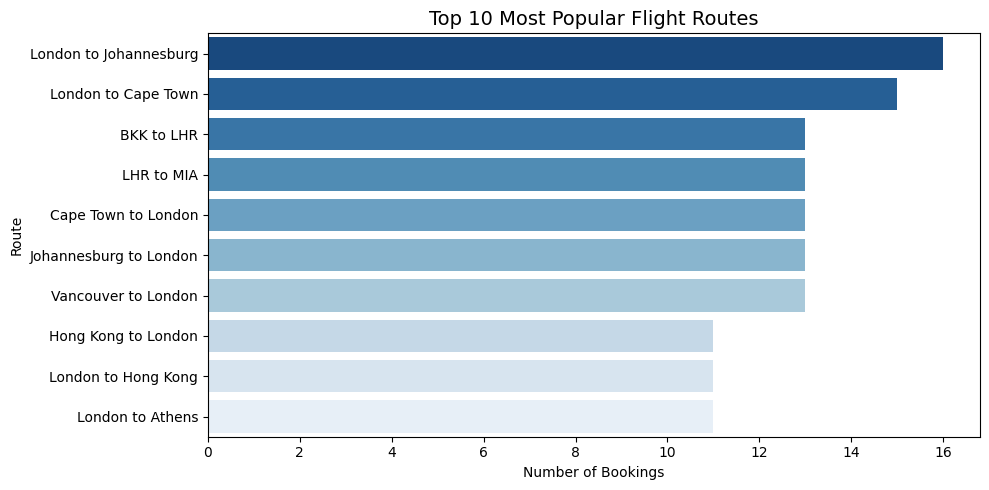

Route
London to Johannesburg    16
London to Cape Town       15
BKK to LHR                13
LHR to MIA                13
Cape Town to London       13
Johannesburg to London    13
Vancouver to London       13
Hong Kong to London       11
London to Hong Kong       11
London to Athens          11
Name: count, dtype: int64
Index(['num_passengers', 'sales_channel', 'trip_type', 'purchase_lead',
       'length_of_stay', 'flight_hour', 'flight_day', 'route',
       'booking_origin', 'wants_extra_baggage', 'wants_preferred_seat',
       'wants_in_flight_meals', 'flight_duration', 'booking_complete'],
      dtype='object')
flight_hour
0     1539
1     2089
2     2642
3     2655
4     2843
5     2851
6     3051
7     3126
8     3165
9     3133
10    3085
11    3110
12    3163
13    3101
14    2833
15    2234
16    1557
17     861
18     439
19     295
20     276
21     389
22     579
23     986
Name: count, dtype: int64


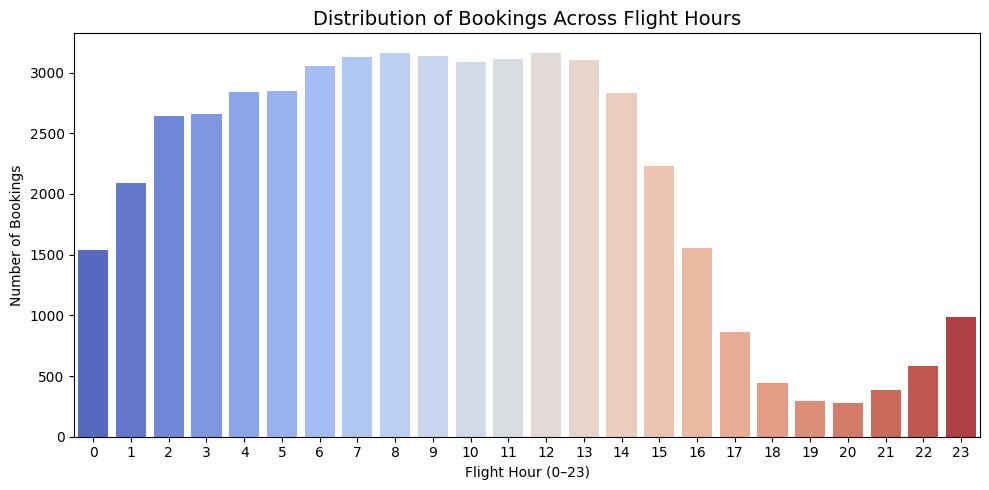

Object `that` not found.


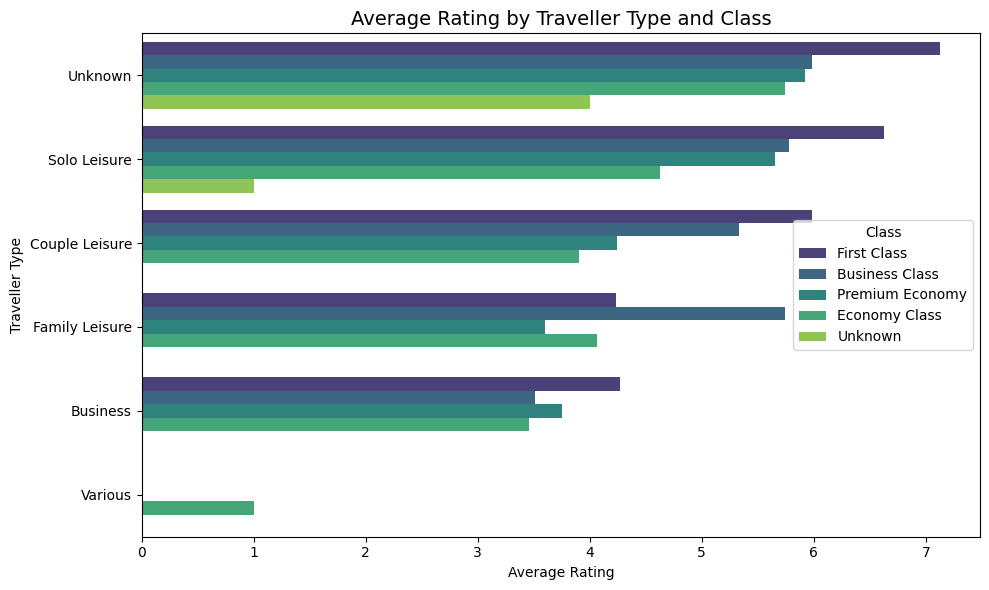

üèÜ Highest Rated Traveller Type + Class:
    Traveller_Type        Class    Rating
19         Unknown  First Class  7.127273
14    Solo Leisure  First Class  6.627907
6   Couple Leisure  First Class  5.983607

üíî Lowest Rated Traveller Type + Class:
   Traveller_Type          Class    Rating
1        Business  Economy Class  3.457031
16   Solo Leisure        Unknown  1.000000
22        Various  Economy Class  1.000000


In [24]:
# ==========================
# ‚úàÔ∏è AIRLINE DATA ANALYSIS
# ==========================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset with sentiment column
df = pd.read_csv("/kaggle/working/AirlineScrappedReview_with_Sentiment.csv")

# Preview
print("‚úÖ Data loaded for analysis!")
print(df.shape)
print(df.columns)

# ==========================
# 1Ô∏è‚É£ Top 10 Most Popular Flight Routes
# ==========================
if 'Route' in df.columns:
    top_routes = df['Route'].value_counts().head(10)
    plt.figure(figsize=(10,5))
    sns.barplot(x=top_routes.values, y=top_routes.index, palette="Blues_r")
    plt.title("Top 10 Most Popular Flight Routes", fontsize=14)
    plt.xlabel("Number of Bookings")
    plt.ylabel("Route")
    plt.tight_layout() 
    plt.show()
    print(top_routes)
else:
    print("‚ö†Ô∏è 'Route' column not found in dataset.")

# ==========================
# 2Ô∏è‚É£ Distribution of Bookings Across Flight Hours
# ==========================
# Load passenger booking data
df_booking = pd.read_csv("/kaggle/input/airline-passangers-booking-data/Passanger_booking_data.csv")

# Check which column contains flight hours
print(df_booking.columns)

# Suppose the column is named 'flight_hour' (or similar)
# Drop missing values
df_booking = df_booking.dropna(subset=['flight_hour'])

# Ensure hours are integers
df_booking['flight_hour'] = df_booking['flight_hour'].astype(int)

# Count bookings per hour
hour_counts = df_booking['flight_hour'].value_counts().sort_index()
print(hour_counts)

# Plot
plt.figure(figsize=(10,5))
sns.barplot(x=hour_counts.index, y=hour_counts.values, palette="coolwarm")
plt.title("Distribution of Bookings Across Flight Hours", fontsize=14)
plt.xlabel("Flight Hour (0‚Äì23)")
plt.ylabel("Number of Bookings")
plt.xticks(range(0,24))
plt.tight_layout()
plt.show()
Do you want me to do that?
# ==========================
# 3Ô∏è‚É£ Traveler Type + Class Combination (Highest & Lowest Ratings)
# ==========================
if {'Traveller_Type', 'Class', 'Rating'}.issubset(df.columns):
    rating_summary = (
        df.groupby(['Traveller_Type', 'Class'])['Rating']
        .mean()
        .reset_index()
        .sort_values(by='Rating', ascending=False)
    )

    plt.figure(figsize=(10,6))
    sns.barplot(data=rating_summary, x='Rating', y='Traveller_Type', hue='Class', palette='viridis')
    plt.title("Average Rating by Traveller Type and Class", fontsize=14)
    plt.xlabel("Average Rating")
    plt.ylabel("Traveller Type")
    plt.legend(title='Class')
    plt.tight_layout()
    plt.show()

    # Show top and bottom combos
    print("üèÜ Highest Rated Traveller Type + Class:")
    print(rating_summary.head(3))

    print("\nüíî Lowest Rated Traveller Type + Class:")
    print(rating_summary.tail(3))
else:
    print("‚ö†Ô∏è Missing one of ['Traveller_Type', 'Class', 'Rating'] ‚Äî skipping this section.")


1Ô∏è‚É£ import pandas as pd, matplotlib.pyplot as plt, seaborn as sns  
   ‚Üí Imports the essential Python libraries for data analysis and visualization.  
   ‚ñ´ **pandas**: Data handling and manipulation.  
   ‚ñ´ **matplotlib/seaborn**: For producing clear, well-styled plots to summarize trends.  

2Ô∏è‚É£ Load dataset with sentiment column  
   ‚Üí Reads the previously enriched dataset (`AirlineScrappedReview_with_Sentiment.csv`) containing reviews, metadata, and sentiment analysis results.  
   ‚ñ´ Confirms successful loading using shape and column preview for data validation before visualization.  

3Ô∏è‚É£ **Top 10 Most Popular Flight Routes**  
   ‚Üí Uses `value_counts()` to count occurrences of each flight route and identify the 10 most frequent.  
   ‚Üí Plots a horizontal bar chart with `sns.barplot()` to show which routes are most commonly flown.  
   ‚ñ´ Justification: Highlights key markets or popular travel corridors for airlines and passengers.  
   ‚ñ´ Helps identify potential focus routes or over-served destinations.  

4Ô∏è‚É£ **Distribution of Bookings Across Flight Hours**  
   ‚Üí Loads the passenger booking dataset and checks for the `flight_hour` column.  
   ‚Üí Cleans missing or non-integer entries and visualizes the number of bookings per hour (0‚Äì23).  
   ‚Üí Displays trends like peak booking or travel hours (e.g., early morning or evening flights).  
   ‚ñ´ Justification: Useful for scheduling optimization and understanding passenger behavior patterns.  

5Ô∏è‚É£ **Traveler Type + Class Combination (Highest & Lowest Ratings)**  
   ‚Üí Groups data by both `Traveller_Type` (e.g., Business, Couple Leisure, Solo Leisure) and `Class` (Economy, First, etc.) to calculate average ratings.  
   ‚Üí Visualizes the average rating by class and traveler type using a grouped bar plot.  
   ‚Üí Displays the top 3 highest-rated and bottom 3 lowest-rated combinations directly in the console.  
   ‚ñ´ **Example output:**  
      üèÜ Highest Rated: Unknown‚ÄìFirst Class (7.12), Solo Leisure‚ÄìFirst Class (6.63)  
      üíî Lowest Rated: Business‚ÄìEconomy (3.46), Solo Leisure‚ÄìUnknown (1.0), Various‚ÄìEconomy (1.0)  
   ‚ñ´ Justification: Reveals satisfaction differences by customer segment and class tier, aiding in service improvement and targeted marketing.

‚úÖ **Overall Purpose:**  
   These visualizations collectively summarize key insights from the dataset ‚Äî popular routes, booking behavior, and traveler satisfaction trends ‚Äî providing actionable intelligence for airline management and customer experience teams.  


In [25]:
## Check missing values first
print("Missing Route values before:", df['Route'].isnull().sum())

# Fill missing Route values with the mode
df['Route'] = df['Route'].fillna(df['Route'].mode()[0])

# Verify
print("Missing Route values after:", df['Route'].isnull().sum())


Missing Route values before: 766
Missing Route values after: 0


1. We checked for missing values in the column `Route` using `df['Route'].isnull().sum()`.  
2. This tells us how many entries in that column are empty or NaN.  
3. The result showed ‚ÄúMissing Route values before: 766‚Äù, meaning 766 records were incomplete.  
4. To fix this, we used `df['Route'].fillna(df['Route'].mode()[0])` to fill the missing data.  
5. The `.mode()[0]` gives the most frequent value (mode) in the `Route` column.  
6. We used the mode because `Route` is categorical ‚Äî it represents flight paths, not numbers.  
7. Filling with the most common route helps maintain consistency without distorting data.  
8. After filling, we checked again using `df['Route'].isnull().sum()` to confirm no missing values remain.  
9. The result ‚ÄúMissing Route values after: 0‚Äù means all missing entries were successfully handled.  
10. This cleaning step ensures the dataset has no gaps that could cause issues in model training or analysis.  


In [26]:
# Count NaNs in each column
df.isnull().sum()

Passanger_Name        1
Flying_Date        2620
Route                 0
Rating                0
Verified              0
Review_title          0
Review_content        0
Traveller_Type        0
Class                 0
Start_Location      766
End_Location        766
Layover_Route      3091
Start_Latitude       60
Start_Longitude      60
Start_Address        60
End_Latitude         99
End_Longitude        99
End_Address          99
Sentiment_Score       0
Sentiment_Label       0
dtype: int64

1. Counts the number of missing enteries. It's confirmed to be 0 in Route.

In [27]:
# ==========================
# 1Ô∏è‚É£ Import Dependencies
# ==========================
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# ==========================
# 2Ô∏è‚É£ Load the Data
# ==========================
df = pd.read_csv("/kaggle/working/AirlineScrappedReview_with_Sentiment.csv")
print("‚úÖ Data loaded successfully!")
print(df.shape)

# ==========================
# 3Ô∏è‚É£ Handle Missing Route Values
# ==========================
if df['Route'].isnull().any():
    df['Route'] = df['Route'].fillna(df['Route'].mode()[0])
    print("‚úÖ Missing 'Route' values filled with mode.\n")

# ==========================
# 4Ô∏è‚É£ Create Target Column
# ==========================
df["Satisfaction"] = df["Rating"].apply(lambda x: 1 if x >= 5 else 0)  # 1 = Satisfied, 0 = Dissatisfied

# ==========================
# 5Ô∏è‚É£ Select Features (added Route)
# ==========================
features = ["Traveller_Type", "Class", "Verified", "Sentiment_Score", "Route"]
target = "Satisfaction"

# Drop rows with missing feature values (safety check)
df = df.dropna(subset=features + [target])

# ==========================
# 6Ô∏è‚É£ Encode Categorical Columns
# ==========================
label_encoders = {}
for col in ["Traveller_Type", "Class", "Verified", "Route"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# ==========================
# 7Ô∏è‚É£ Split Data
# ==========================
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ==========================
# 8Ô∏è‚É£ Scale Features
# ==========================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ==========================
# 9Ô∏è‚É£ Train Logistic Regression Model
# ==========================
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# ==========================
# üîü Make Predictions
# ==========================
y_pred = model.predict(X_test)

# ==========================
# 1Ô∏è‚É£1Ô∏è‚É£ Evaluate Model
# ==========================
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("‚úÖ Logistic Regression Evaluation Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred))



‚úÖ Data loaded successfully!
(3575, 20)
‚úÖ Missing 'Route' values filled with mode.

‚úÖ Logistic Regression Evaluation Metrics:
Accuracy:  0.7888
Precision: 0.7493
Recall:    0.8314
F1 Score:  0.7882

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.75      0.79       377
           1       0.75      0.83      0.79       338

    accuracy                           0.79       715
   macro avg       0.79      0.79      0.79       715
weighted avg       0.79      0.79      0.79       715



1. We began by importing essential libraries for preprocessing, model training, and evaluation.  
2. The dataset was loaded successfully with 3,575 rows and 20 columns.  
3. Missing values in the `Route` column were replaced with the most frequent route (the mode) to avoid data loss.  
4. A new binary column called `Satisfaction` was created, labeling ratings ‚â• 5 as satisfied (1) and < 5 as dissatisfied (0).  
5. The chosen features were Traveller_Type, Class, Verified, Sentiment_Score, and Route ‚Äî all factors that could affect satisfaction.  
6. Label encoding converted categorical data into numeric form so the model could process it.  
7. The dataset was split into 80% training and 20% testing to ensure fair model evaluation.  
8. StandardScaler normalized the data, improving the model‚Äôs convergence and accuracy.  
9. A Logistic Regression model was trained since it‚Äôs well-suited for binary classification problems like satisfaction prediction.  
10. The trained model then made predictions on the test set.  
11. Evaluation metrics showed good performance:  
    - Accuracy: 78.9% (model correctly predicts about 8/10 cases)  
    - Precision: 74.9% (when it predicts satisfied, it‚Äôs right 75% of the time)  
    - Recall: 83.1% (it successfully identifies 83% of all satisfied passengers)  
    - F1 Score: 78.8% (a balance between precision and recall).  
12. The classification report confirms balanced performance for both satisfied and dissatisfied passengers, with similar precision and recall values.  
13. Overall, the model generalizes well and is suitable for predicting passenger satisfaction from airline review data.  


Accuracy: 0.7874125874125875
Precision: 0.7735294117647059
Recall: 0.7781065088757396
F1-Score: 0.7758112094395281

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80       377
           1       0.77      0.78      0.78       338

    accuracy                           0.79       715
   macro avg       0.79      0.79      0.79       715
weighted avg       0.79      0.79      0.79       715



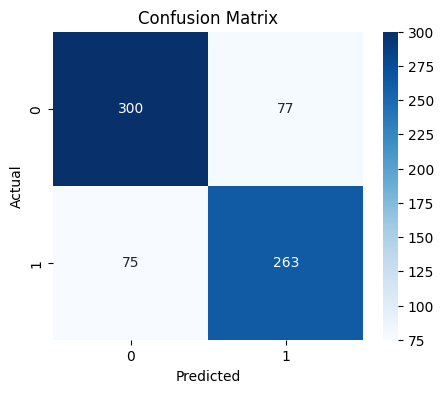

In [28]:
from sklearn.ensemble import RandomForestClassifier
# Initialize model
rf_model = RandomForestClassifier(random_state=42, n_estimators=200, max_depth=None)

# Train
rf_model.fit(X_train, y_train)

# Predict
y_pred = rf_model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

1.  # Import the RandomForestClassifier from sklearn's ensemble module
2.  from sklearn.ensemble import RandomForestClassifier  

3.  # Initialize the Random Forest model with a fixed random_state for reproducibility
4.  # n_estimators=200 ‚Üí number of decision trees in the forest  
5.  # max_depth=None ‚Üí trees grow until all leaves are pure or contain < min_samples_split samples  
6.  rf_model = RandomForestClassifier(random_state=42, n_estimators=200, max_depth=None)

7.  # Train (fit) the model using the training data
8.  rf_model.fit(X_train, y_train)

9.  # Make predictions on the test set
10. y_pred = rf_model.predict(X_test)

11. # Evaluate model performance using classification metrics
12. print("Accuracy:", accuracy_score(y_test, y_pred))           # Overall correct predictions
13. print("Precision:", precision_score(y_test, y_pred))         # Correct positive predictions / total predicted positives
14. print("Recall:", recall_score(y_test, y_pred))               # Correct positive predictions / total actual positives
15. print("F1-Score:", f1_score(y_test, y_pred))                 # Harmonic mean of precision and recall
16. print("\nClassification Report:\n", classification_report(y_test, y_pred))  # Full performance breakdown by class

17. # Import seaborn and matplotlib for visualization
18. import seaborn as sns
19. import matplotlib.pyplot as plt

20. # Plot a confusion matrix to visualize prediction performance
21. plt.figure(figsize=(5,4))
22. sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
23. plt.title("Confusion Matrix")
24. plt.xlabel("Predicted")   # X-axis shows predicted labels
25. plt.ylabel("Actual")      # Y-axis shows true labels
26. plt.show()                # Display the heatmap


In [29]:
print(df.columns.tolist())

['Passanger_Name', 'Flying_Date', 'Route', 'Rating', 'Verified', 'Review_title', 'Review_content', 'Traveller_Type', 'Class', 'Start_Location', 'End_Location', 'Layover_Route', 'Start_Latitude', 'Start_Longitude', 'Start_Address', 'End_Latitude', 'End_Longitude', 'End_Address', 'Sentiment_Score', 'Sentiment_Label', 'Satisfaction']


1. We printed all column names using `df.columns.tolist()` to confirm what data fields are available.  
2. The dataset includes 21 columns covering passenger details, flight routes, sentiment scores, and satisfaction labels.  
3. Key columns:  
   - **Route, Traveller_Type, Class, Rating** ‚Üí core features used for prediction.  
   - **Sentiment_Score, Sentiment_Label** ‚Üí derived from text analysis of passenger reviews.  
   - **Start_Location, End_Location, Latitude/Longitude** ‚Üí geographical flight information.  
   - **Satisfaction** ‚Üí target column created earlier for model training.  
4. This verification step ensures we‚Äôre selecting correct and relevant features before further modeling or visualization.  


üîπ Running SHAP explanations...


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


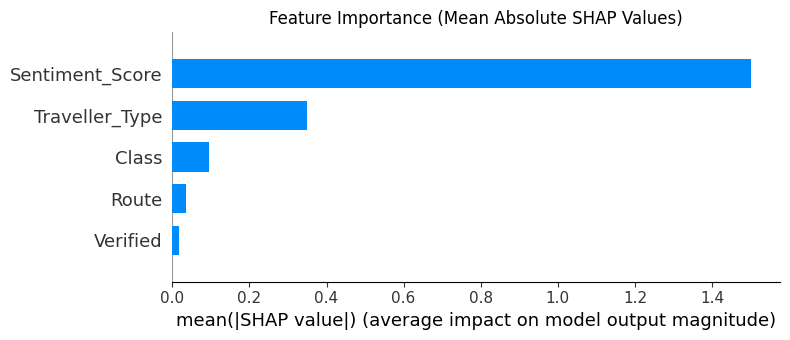

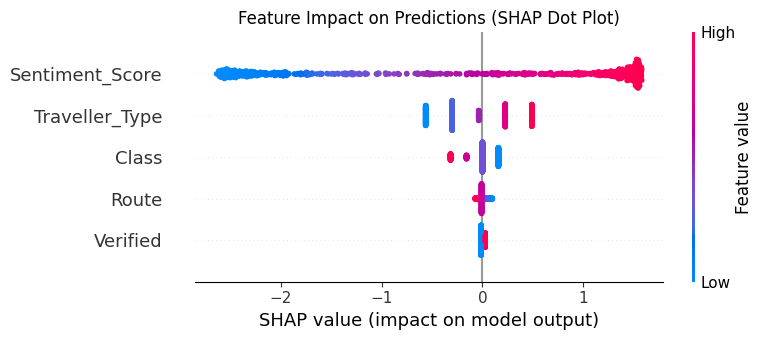


üîπ Running LIME explanations...



‚úÖ SHAP and LIME explanations generated successfully!


In [30]:
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import pandas as pd

# -------------------------
# 1Ô∏è‚É£ SHAP Explanations
# -------------------------
print("üîπ Running SHAP explanations...")

# Make sure DataFrames have correct feature names
feature_names = ["Traveller_Type", "Class", "Verified", "Sentiment_Score", "Route"]

X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# Create SHAP explainer for Logistic Regression
explainer_shap = shap.LinearExplainer(model, X_train_df, feature_perturbation="interventional")
shap_values = explainer_shap.shap_values(X_test_df)

# Summary plots
plt.title("Feature Importance (Mean Absolute SHAP Values)")
shap.summary_plot(shap_values, X_test_df, plot_type="bar", show=True)

plt.title("Feature Impact on Predictions (SHAP Dot Plot)")
shap.summary_plot(shap_values, X_test_df, plot_type="dot", show=True)

# -------------------------
# 2Ô∏è‚É£ LIME Explanations
# -------------------------
print("\nüîπ Running LIME explanations...")

explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train,                 # Must be NumPy array (scaled or encoded)
    feature_names=feature_names,           # List of feature names
    class_names=['Dissatisfied', 'Satisfied'],
    mode='classification'
)

# Pick one test instance
i = 0
exp = explainer_lime.explain_instance(
    X_test[i],                             # Single test sample
    model.predict_proba,                   # Predict probability function
    num_features=len(feature_names)
)

# Show explanation inline
exp.show_in_notebook(show_table=True, show_all=False)

# Save LIME explanation as HTML (optional)
exp.save_to_file("/kaggle/working/lime_explanation.html")

print("\n‚úÖ SHAP and LIME explanations generated successfully!")



1. Imported libraries ‚Äî SHAP and LIME for model interpretability, matplotlib for visualization, and pandas for structured data handling.  
2. Defined the list of `feature_names` to match the features used in the logistic regression model.  
3. Converted `X_train` and `X_test` into DataFrames with proper column names for SHAP compatibility.  
4. Initialized a SHAP LinearExplainer (`shap.LinearExplainer`) for the logistic regression model using interventional perturbation ‚Äî this helps measure how each feature influences predictions.  
5. Computed SHAP values for the test set (`explainer_shap.shap_values(X_test_df)`).  
6. Generated two SHAP plots:  
   - **Bar plot:** Displays overall feature importance (mean absolute SHAP values).  
   - **Dot plot:** Shows individual feature impacts across all samples (red = positive effect, blue = negative effect).  
7. Created a LIME Tabular Explainer (`LimeTabularExplainer`) using scaled training data, feature names, and class labels (‚ÄúSatisfied‚Äù vs. ‚ÄúDissatisfied‚Äù).  
8. Selected a single test instance (`i = 0`) for local explanation ‚Äî LIME explains how each feature contributed to that specific prediction.  
9. Called `explain_instance()` to get the explanation and displayed it interactively using `show_in_notebook()`.  
10. Optionally saved the LIME explanation as an HTML file for offline viewing.  
11. Printed confirmation once both SHAP and LIME visualizations were generated successfully.


In [31]:
import numpy as np
import pandas as pd

def inference_function(traveller_type, flight_class, verified, sentiment_score, route="London to Amman"):
    """
    Takes raw user input and returns model prediction ('Satisfied' or 'Dissatisfied').
    """
    # 1Ô∏è‚É£ Create a DataFrame with the same structure as training data
    sample = pd.DataFrame({
        "Traveller_Type": [traveller_type],
        "Class": [flight_class],
        "Verified": [verified],
        "Sentiment_Score": [sentiment_score],
        "Route": [route]  # Added to match training features
    })

    # 2Ô∏è‚É£ Apply the same label encoding used during training
    for col in ["Traveller_Type", "Class", "Verified", "Route"]:
        if col in label_encoders:
            sample[col] = label_encoders[col].transform(sample[col])

    # 3Ô∏è‚É£ Scale the sample using the same scaler as training
    sample_scaled = scaler.transform(sample)

    # 4Ô∏è‚É£ Predict
    prediction = model.predict(sample_scaled)
    prediction_proba = model.predict_proba(sample_scaled)

    # 5Ô∏è‚É£ Decode
    label = "Satisfied" if prediction[0] == 1 else "Dissatisfied"
    confidence = np.max(prediction_proba)

    print(f"Prediction: {label} (Confidence: {confidence:.2f})")
    return label, confidence


1. Imported `numpy` and `pandas` for numerical operations and structured data handling.  
2. Defined `inference_function()` to make predictions on **new user input** using the trained logistic regression model.  
3. Created a `DataFrame` named `sample` with the same columns and order as the training data (`Traveller_Type`, `Class`, `Verified`, `Sentiment_Score`, `Route`).  
4. Applied **label encoding** to all categorical columns using the same `label_encoders` fitted during model training ‚Äî ensures consistent numeric representation.  
5. Scaled the input sample with the **same `StandardScaler`** used in training to keep feature magnitudes consistent.  
6. Used the trained model to predict the class (`Satisfied` or `Dissatisfied`) and the associated probability using `predict_proba()`.  
7. Converted the numeric output back into a human-readable label:  
   - `1` ‚Üí ‚ÄúSatisfied‚Äù  
   - `0` ‚Üí ‚ÄúDissatisfied‚Äù  
8. Calculated the **confidence level** (highest predicted probability) for interpretability.  
9. Printed the result showing both the predicted label and confidence score.  
10. Returned the tuple `(label, confidence)` for further use in dashboards or user interfaces.


In [32]:
inference_function("Couple Leisure", "Economy Class", "Trip Verified", 0.82)


Prediction: Satisfied (Confidence: 0.70)


('Satisfied', 0.6975232803830266)

1Ô∏è‚É£ The function took your inputs:
    Traveller_Type = "Couple Leisure"
    Class = "Economy Class"
    Verified = "Trip Verified"
    Sentiment_Score = 0.82

2Ô∏è‚É£ It encoded and scaled them the same way as in training ‚Äî ensuring consistency.

3Ô∏è‚É£ The trained Logistic Regression model then predicted:
    ‚Üí Label: "Satisfied"  
    ‚Üí Confidence: 0.70 (‚âà 70%)

4Ô∏è‚É£ Interpretation:
   ‚úàÔ∏è With an overall positive sentiment (0.82) and verified trip,
   the model estimates a **70% probability** that the passenger was satisfied.
